# Graph My Task Statistics

We'll use the matplotlib [Stacked Area Plot](https://www.python-graph-gallery.com/stacked-area-plot/) to visualize the accumulation of incoming vs. completed tasks over time.

In [4]:
%matplotlib widget

import math
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import mplcursors

from main import AmazingCloudAntClient

client = AmazingCloudAntClient()
chart_data = client.get_task_stats_for_chart()

date_fmt = DateFormatter("%Y-%m-%d")

KeyError: 'db'

Avg New Tasks per Day: 5.7611940298507465
Avg Completed Tasks per Day: 5.623880597014925
Avg Backlog Increase: 0.1373134328358209


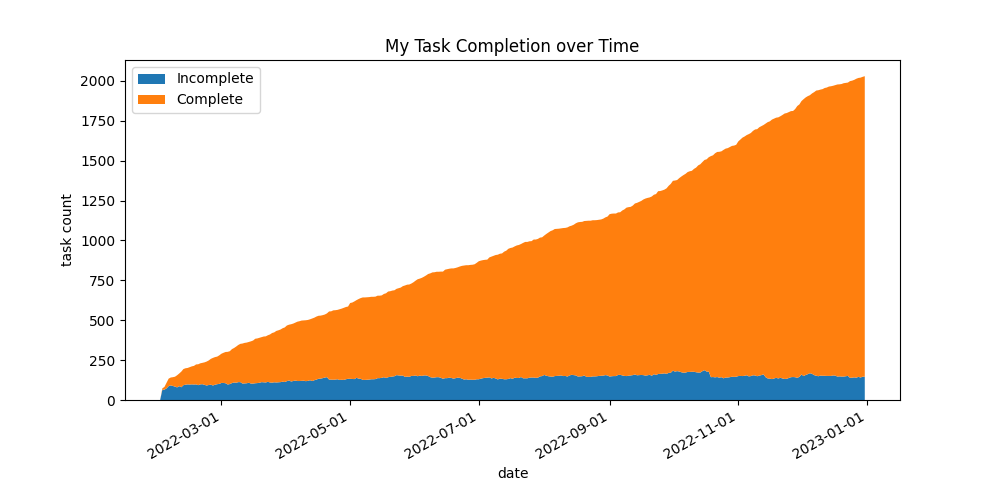

/Users/william/workspace/personal/amazing-marvin/venv/lib/python3.9/site-packages/mplcursors/_pick_info.py:162: UserWarning: Pick support for PolyCollection is missing.
  warnings.warn(f"Pick support for {type(artist).__name__} is missing.")


In [ ]:
%matplotlib widget
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# Set up figure
ax.stackplot(
    chart_data["dates"],
    chart_data["incomplete"],
    chart_data["complete"],
    labels=['Incomplete','Complete'],
)
plt.legend(loc='upper left')
plt.title("My Task Completion over Time")
plt.xlabel('date')
plt.ylabel('task count')

# Format Dates
fig.autofmt_xdate()
ax.xaxis.set_major_formatter(date_fmt)

mplcursors.cursor(hover=True)

# Quick Stats
cpd = chart_data["complete"][-1] / len(chart_data["dates"])
ipd = (chart_data["incomplete"][-1] - 100) / len(chart_data["dates"])
print("Avg New Tasks per Day:", cpd+ipd)
print("Avg Completed Tasks per Day:", cpd)
print("Avg Backlog Increase:", ipd)

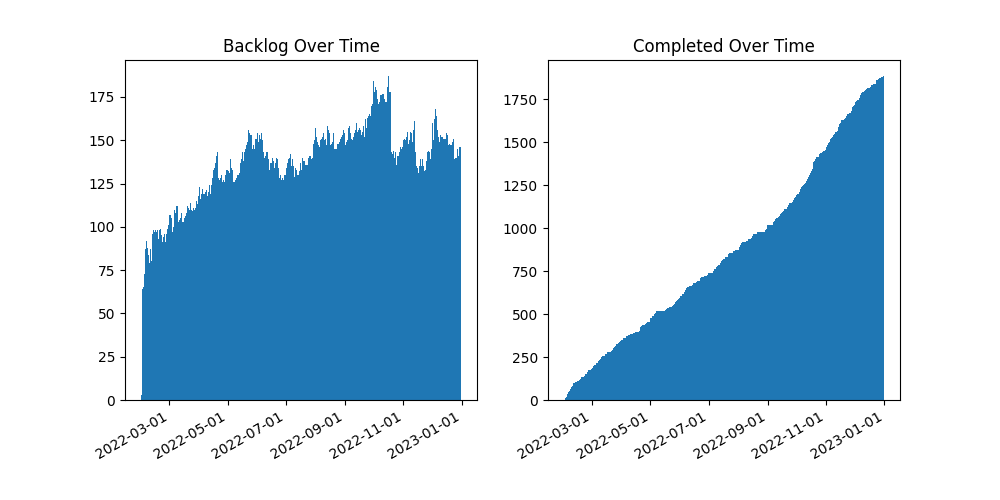

In [ ]:
# Set up figures
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 5))
ax1.title.set_text("Backlog Over Time")
ax2.title.set_text("Completed Over Time")
ax1.bar(chart_data["dates"], chart_data["incomplete"], width=1)
ax2.bar(chart_data["dates"], chart_data["complete"], width=1)

# Format dates
fig.autofmt_xdate()
date_form = DateFormatter("%Y-%m-%d")
ax1.xaxis.set_major_formatter(date_form)
ax2.xaxis.set_major_formatter(date_form)

# mplcursors.cursor(hover=True)

In [ ]:
# Tasks Added / Removed Today
today = dt.datetime.now()
week_ago = today - dt.timedelta(days=7)
today_stats = client.get_tasks_added_removed_between(start=week_ago, end=today)

print("THIS WEEK'S TASK STATS")

print(f'{ len(today_stats["created"]) } Task/s Created')
for t in today_stats["created"][:5]:
    print(f'  - { t["doc"]["title"] }')

print('')

print(f'{ len(today_stats["completed"]) } Task/s Completed')
for t in today_stats["completed"][:5]:
    print(f'  - { t["doc"]["title"] }')

THIS WEEK'S TASK STATS
37 Task/s Created
  - Reminder for sleep: magnesium L-Threonate and theanine
  - Reminder for sleep: magnesium L-Threonate and theanine
  - Reminder for sleep: magnesium L-Threonate and theanine
  - Reminder for sleep: magnesium L-Threonate and theanine
  - Reminder for sleep: magnesium L-Threonate and theanine

35 Task/s Completed
  - Reminder for sleep: magnesium L-Threonate and theanine
  - Reminder for sleep: magnesium L-Threonate and theanine
  - Reminder for sleep: magnesium L-Threonate and theanine
  - Reminder for sleep: magnesium L-Threonate and theanine
  - Reminder for sleep: magnesium L-Threonate and theanine


NOTE: Negative cycle times are recurring tasks that were marked 'done' before the date of recurrence.

Q1: 0.3346131134259259
Q3: 4.932485711805556
IQR: 4.59787259837963
outer_fence: 18.726103506944444
95th: 50.84231029629625
99th: 250.35075643148147

191 outliers of 1899: [18.806890127314816, 18.862342094907408, 18.992750949074075] ... [272.8811160648148, 278.54671097222223, 282.1680879861111]


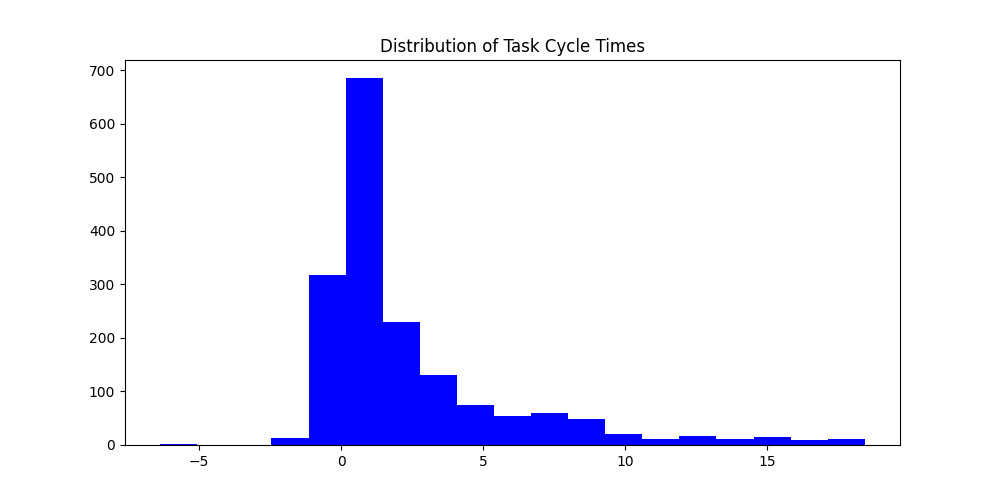

In [ ]:
# Look at distribution of task cycle times
tasks = client.get_all_tasks()
cycle_times = sorted([t.cycle_time for t in tasks if t.done])

q1, q3, n5, n9 = np.percentile(cycle_times, [25, 75, 95, 99])
iqr = q3 - q1
outer_fence = q3 + 3*(iqr)

print("NOTE: Negative cycle times are recurring tasks that were marked 'done' before the date of recurrence.")

print(f"""
Q1: {q1}
Q3: {q3}
IQR: {iqr}
outer_fence: {outer_fence}
95th: {n5}
99th: {n9}
""")

outliers = sorted([c for c in cycle_times if c >= outer_fence])
print(f"{len(outliers)} outliers of {len(cycle_times)}: {outliers[:3]} ... {outliers[-3:]}")

# Filter out outliers
a = [i for i in cycle_times if i not in outliers]

# Plot it
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.hist(a, bins=math.ceil(max(a)), histtype ='bar', facecolor='blue')
ax.title.set_text("Distribution of Task Cycle Times")


NOTE: Negative cycle times are recurring tasks that were marked 'done' before the date of recurrence.

Q1: 0.6049716782407407
Q3: 7.664501030092593
IQR: 7.059529351851852
outer_fence: 28.843089085648153
95th: 88.7624455949074
99th: 258.27536989953705

136 outliers of 1273: [<main.Task object at 0x125654af0>, <main.Task object at 0x125664850>, <main.Task object at 0x1256513d0>] ... [<main.Task object at 0x125667f10>, <main.Task object at 0x125650d30>, <main.Task object at 0x12564edf0>]


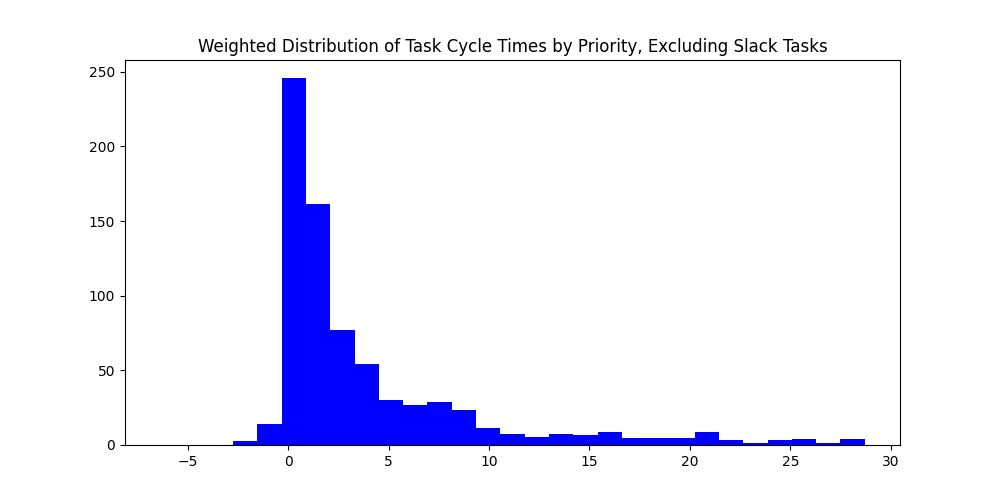

In [ ]:
# CYCLE TIMES EXCLUDING TASKS MENTIONING SLACK AND WEIGHTED BY PRIORITY
tasks_no_slack = sorted([t for t in tasks if t.done and not 'slack' in t.data["doc"]["title"].lower()], key=lambda t: t.cycle_time)
cycle_times_no_slack = [t.cycle_time for t in tasks_no_slack]

q1, q3, n5, n9 = np.percentile(cycle_times_no_slack, [25, 75, 95, 99])
iqr = q3 - q1
outer_fence = q3 + 3*(iqr)

print("NOTE: Negative cycle times are recurring tasks that were marked 'done' before the date of recurrence.")

print(f"""
Q1: {q1}
Q3: {q3}
IQR: {iqr}
outer_fence: {outer_fence}
95th: {n5}
99th: {n9}
""")

# Filter Outliers
outliers = [t for t in tasks_no_slack if t.cycle_time >= outer_fence]
print(f"{len(outliers)} outliers of {len(tasks_no_slack)}: {outliers[:3]} ... {outliers[-3:]}")

tasks_no_slack_or_outliers = [t for t in tasks_no_slack if t not in outliers]
cycles_no_slack_or_outliers = [t.cycle_time for t in tasks_no_slack_or_outliers]
weights = [t.is_starred/3 for t in tasks_no_slack_or_outliers]

# Plot it
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.hist(
    cycles_no_slack_or_outliers,
    bins=math.ceil(max(cycles_no_slack_or_outliers)),
    weights=weights,
    histtype ='bar',
    facecolor='blue',
)
ax.title.set_text("Weighted Distribution of Task Cycle Times by Priority, Excluding Slack Tasks")
mplcursors.cursor(hover=True)